In [47]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import copy
import numpy as np
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

rcParams['figure.figsize'] = 12, 8

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [48]:
!nvidia-smi
print(torch.cuda.is_available())

Fri Oct  4 09:02:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.09                 Driver Version: 532.09       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A1000 Laptop GPU   WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8                4W /  N/A|   1078MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [49]:
train_data = arff.loadarff('ECG5000/ECG5000_TRAIN.arff')
train_df = pd.DataFrame(train_data[0])
train_df['target'] = pd.to_numeric(train_df['target'])

test_data = arff.loadarff('ECG5000/ECG5000_TEST.arff')
test_df = pd.DataFrame(test_data[0])
test_df['target'] = pd.to_numeric(test_df['target'])
print(train_df.shape, test_df.shape)

(500, 141) (4500, 141)


In [50]:
print(train_df.head())

       att1      att2      att3      att4      att5      att6      att7  \
0 -0.112522 -2.827204 -3.773897 -4.349751 -4.376041 -3.474986 -2.181408   
1 -1.100878 -3.996840 -4.285843 -4.506579 -4.022377 -3.234368 -1.566126   
2 -0.567088 -2.593450 -3.874230 -4.584095 -4.187449 -3.151462 -1.742940   
3  0.490473 -1.914407 -3.616364 -4.318823 -4.268016 -3.881110 -2.993280   
4  0.800232 -0.874252 -2.384761 -3.973292 -4.338224 -3.802422 -2.534510   

       att8      att9     att10  ...    att132    att133    att134    att135  \
0 -1.818286 -1.250522 -0.477492  ...  0.792168  0.933541  0.796958  0.578621   
1 -0.992258 -0.754680  0.042321  ...  0.538356  0.656881  0.787490  0.724046   
2 -1.490659 -1.183580 -0.394229  ...  0.886073  0.531452  0.311377 -0.021919   
3 -1.671131 -1.333884 -0.965629  ...  0.350816  0.499111  0.600345  0.842069   
4 -1.783423 -1.594450 -0.753199  ...  1.148884  0.958434  1.059025  1.371682   

     att136    att137    att138    att139    att140  target  
0  0.2

<BarContainer object of 5 artists>

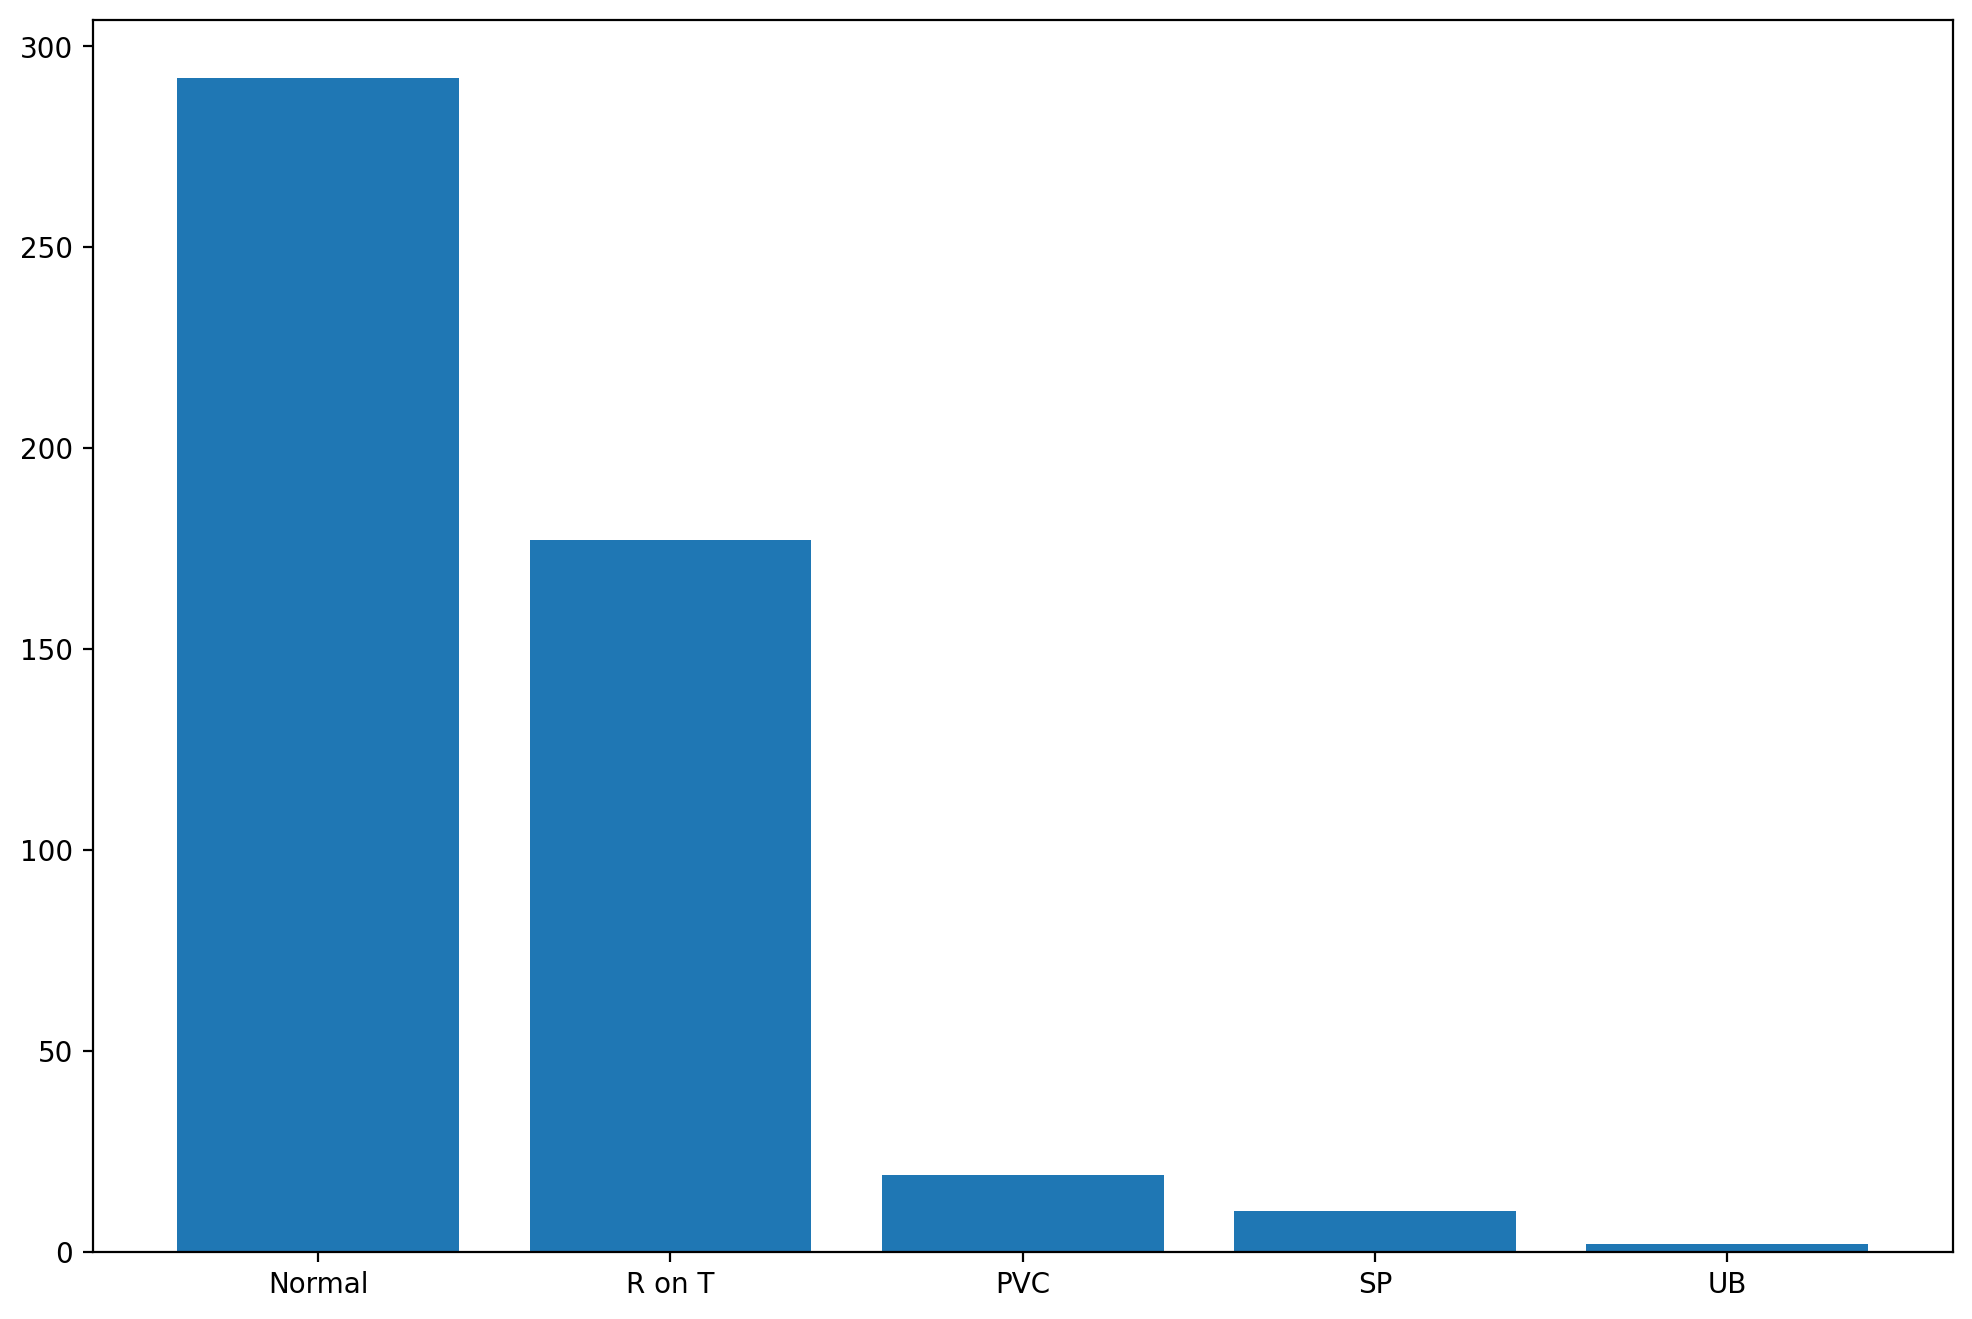

In [51]:

# Explore data
class_normal = 1
class_names = ['Normal','R on T','PVC','SP','UB']

plt.bar(class_names, train_df['target'].value_counts())

Text(0.5, 1.0, 'Class distribution in training data')

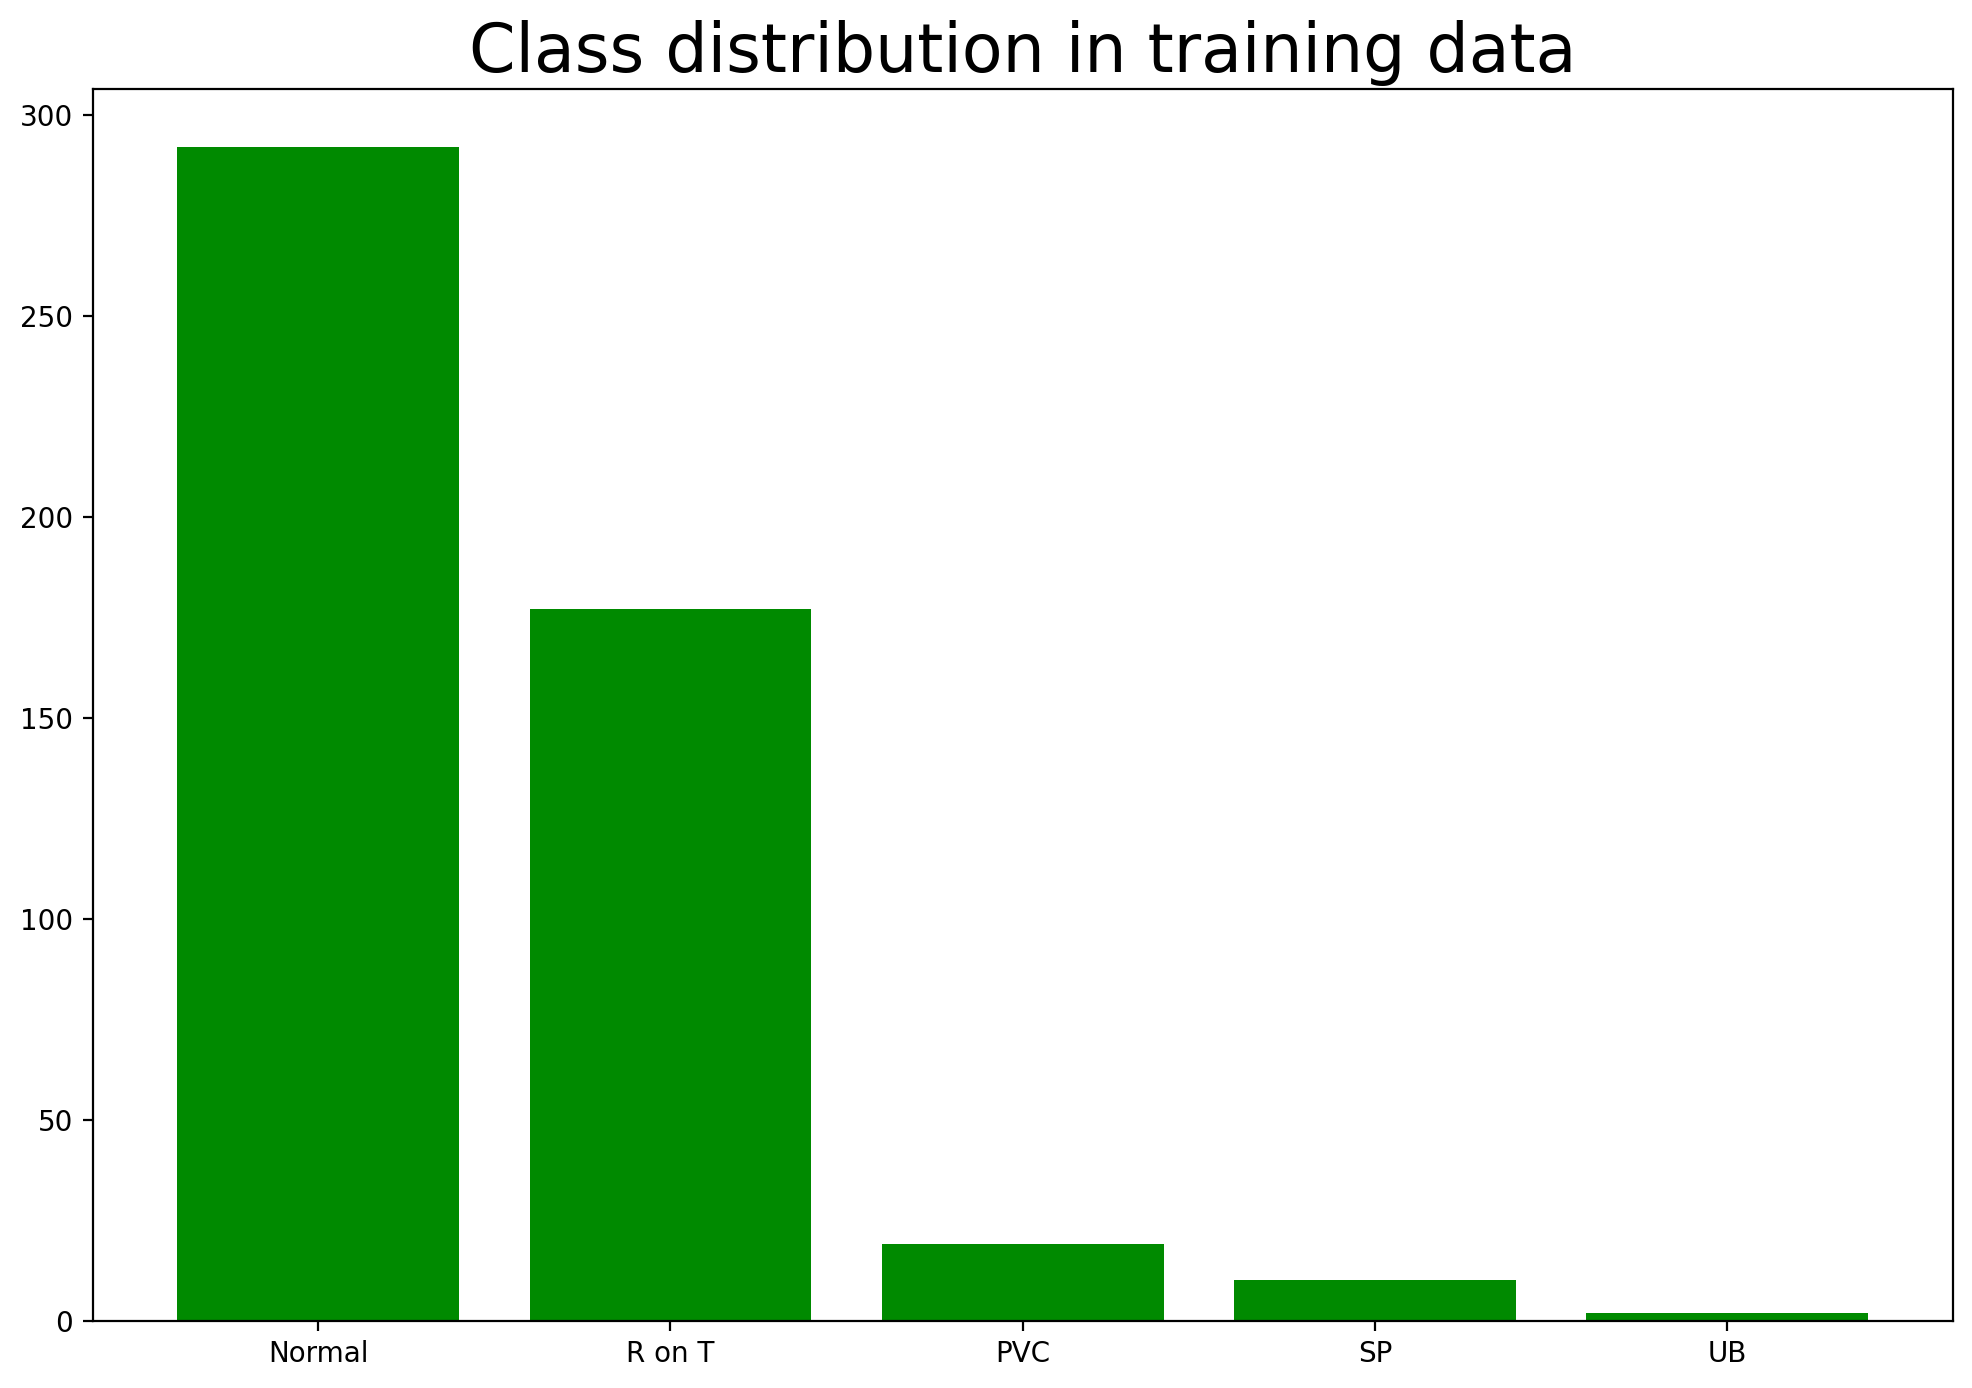

In [52]:
plt.bar(class_names, train_df['target'].value_counts(), color='#008A00')
plt.title('Class distribution in training data', fontsize=24)

In [53]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2, color='#008A00')
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

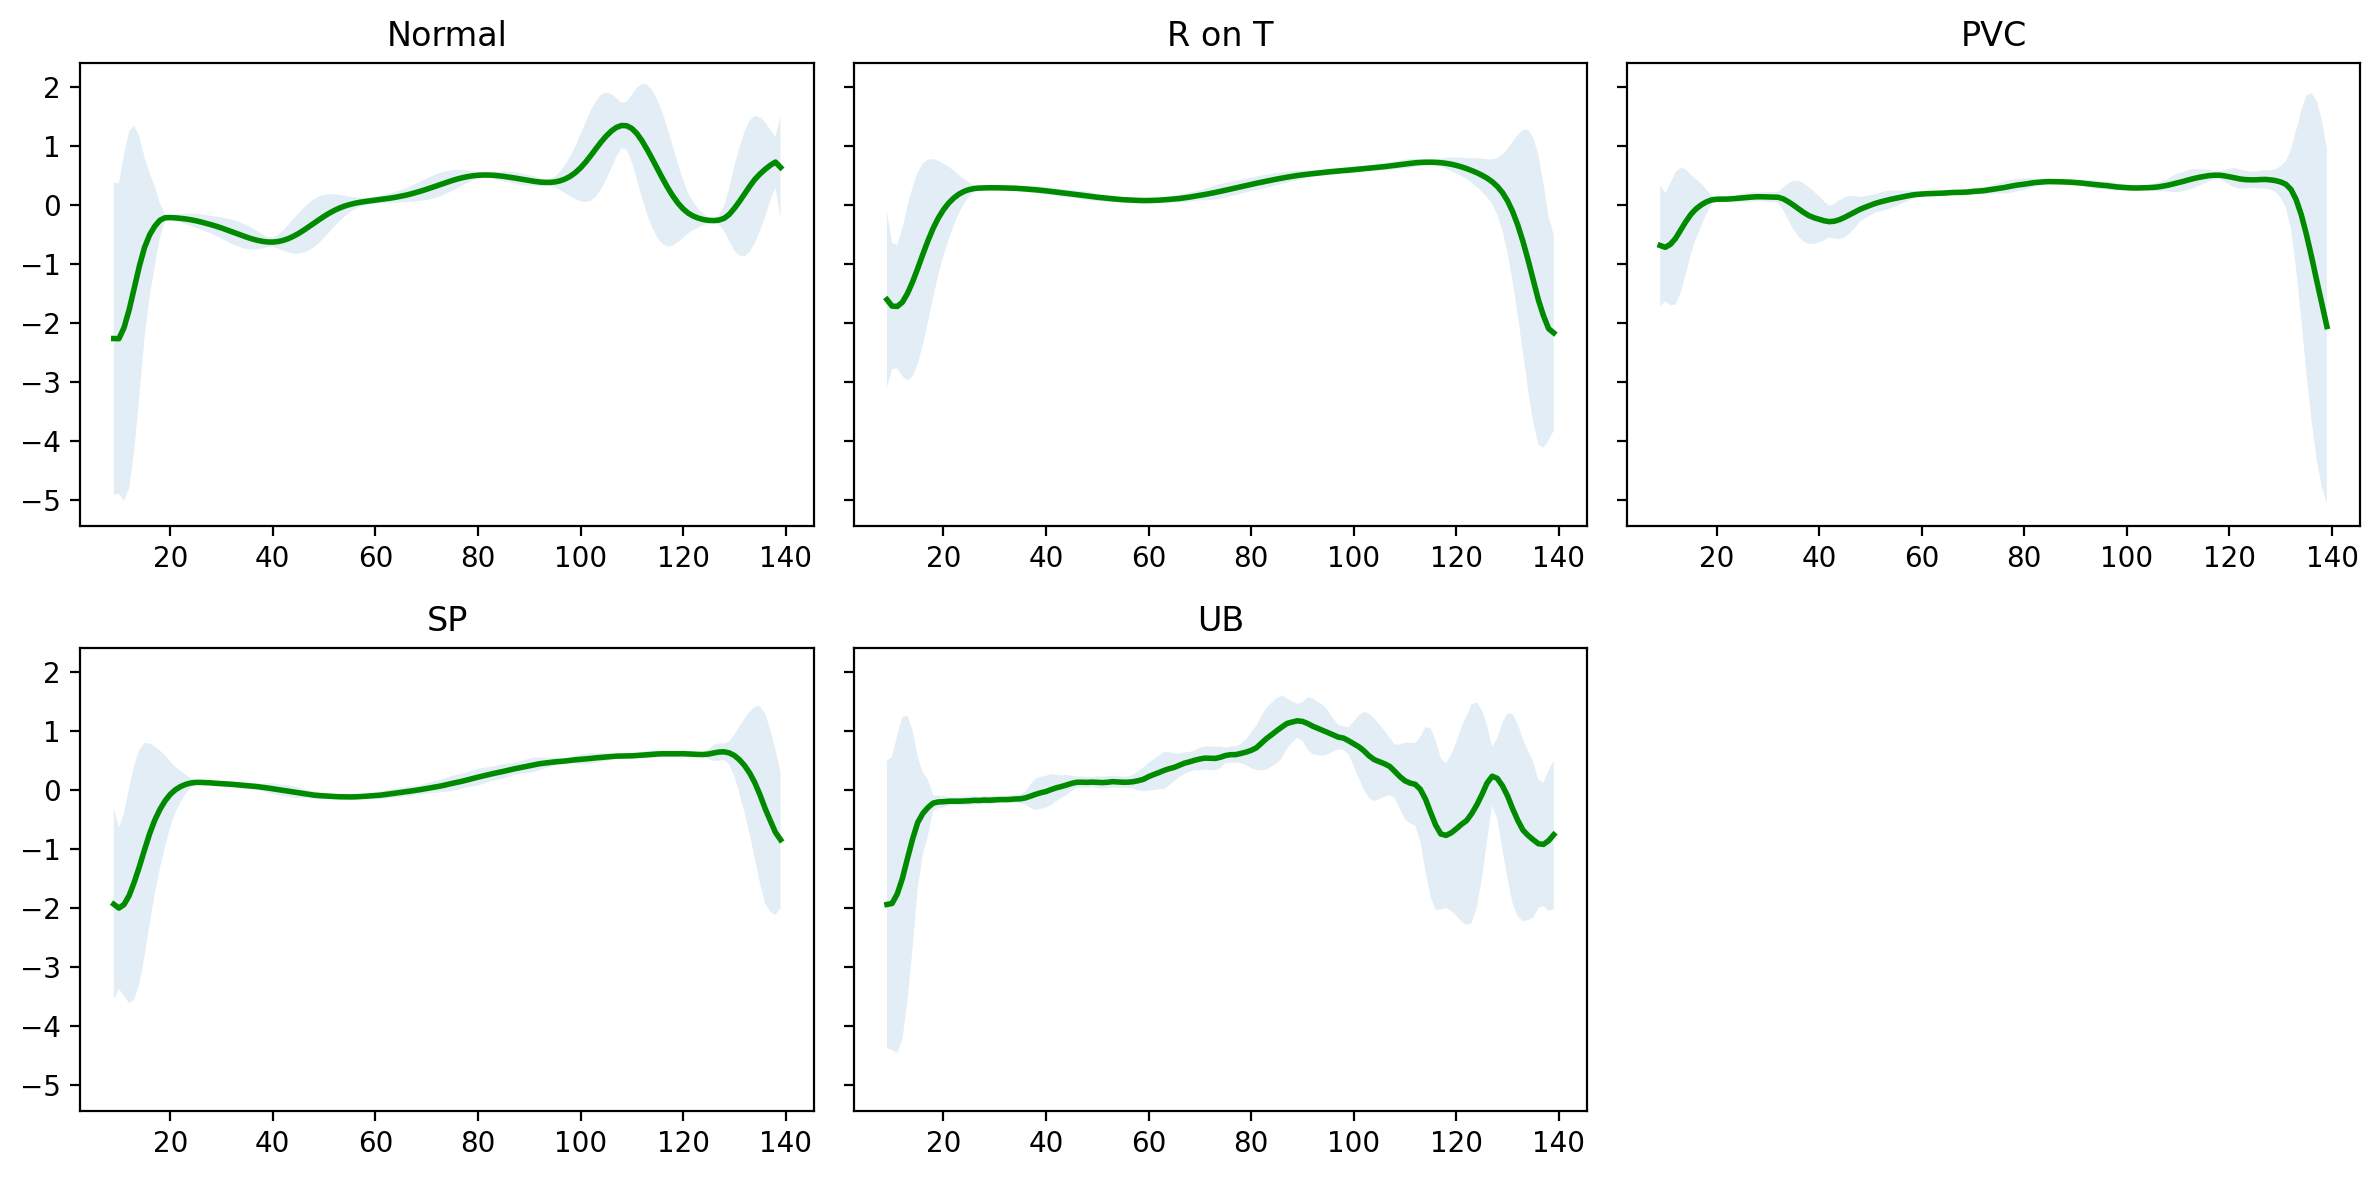

In [54]:
classes = train_df.target.unique()

fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(12, 6)
)

for i, _class in enumerate(classes):
  ax = axs.flat[i]
  data = train_df[train_df.target == _class].drop(labels='target', axis=1).mean(axis=0).to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout()

In [55]:
# Anomaly detection
normal_df = train_df[train_df['target'] == class_normal]
print('Nr of normal records:', len(normal_df))

Nr of normal records: 292


In [56]:
# Merge all abnormal targets to anomalies
anomaly_df = train_df[train_df['target'] != class_normal]
print('Nr of anomaly records:', len(anomaly_df))

Nr of anomaly records: 208


In [57]:
# Split the normal examples into train, validation and test sets:
train_df, val_df = train_test_split(
    normal_df,
    test_size=0.10,
    random_state=seed
)

In [58]:
# Convert to tensors
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(seq).unsqueeze(1).float() for seq in sequences]
    _, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

train_dataset, sequence_length, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
print('train_dataset size:', len(train_dataset))
print('val_dataset size:', len(val_dataset))

train_dataset size: 262
val_dataset size: 30


In [59]:
class Encoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=embedding_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))

        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)

        return hidden_n.reshape((self.n_features, self.embedding_dim))
  
class Decoder(nn.Module):

    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features

        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=input_dim,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )

        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))

        return self.output_layer(x)

class RecurrentAutoencoder(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

print(sequence_length, n_features)

model = RecurrentAutoencoder(seq_len=sequence_length, n_features=n_features)
model = model.to(device)

cuda
141 1


In [61]:
# Training
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    criterion = nn.L1Loss(reduction='sum').to(device)

    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0

    for epoch in range(1, n_epochs+1):
        train_losses = []
        model.train()
        
        for seq_true in train_dataset:

            optimizer.zero_grad()

            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)

            loss = criterion(seq_pred, seq_true)

            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        
        with torch.no_grad():
            for seq_true in val_dataset:

                seq_true = seq_true.to(device)
                seq_pred = model(seq_true)

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print('Epoch {}: train loss {} val loss {}'.format(epoch, train_loss, val_loss))

    model.load_state_dict(best_model_wts)
    return model.eval(), history

# Run training script
model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=150
)

Epoch 1: train loss 82.69350801715414 val loss 72.77725512186686
Epoch 2: train loss 88.85371302830355 val loss 85.3824956258138
Epoch 3: train loss 68.7734160386879 val loss 60.30558547973633
Epoch 4: train loss 58.14956440816399 val loss 55.47215194702149
Epoch 5: train loss 56.91992181676035 val loss 57.16113204956055
Epoch 6: train loss 55.83914107402772 val loss 52.82743428548177
Epoch 7: train loss 54.8812715952633 val loss 53.349165725708005
Epoch 8: train loss 53.94110491803584 val loss 51.66113408406576
Epoch 9: train loss 54.03438659842688 val loss 53.103546396891275
Epoch 10: train loss 53.50830107244826 val loss 51.67834002176921
Epoch 11: train loss 53.67014053577685 val loss 50.84064585367839
Epoch 12: train loss 53.755213671968185 val loss 53.837001673380534
Epoch 13: train loss 53.40880242558836 val loss 51.53970947265625
Epoch 14: train loss 54.27516488810532 val loss 52.54717597961426
Epoch 15: train loss 53.33850738292432 val loss 51.583068974812825
Epoch 16: train l

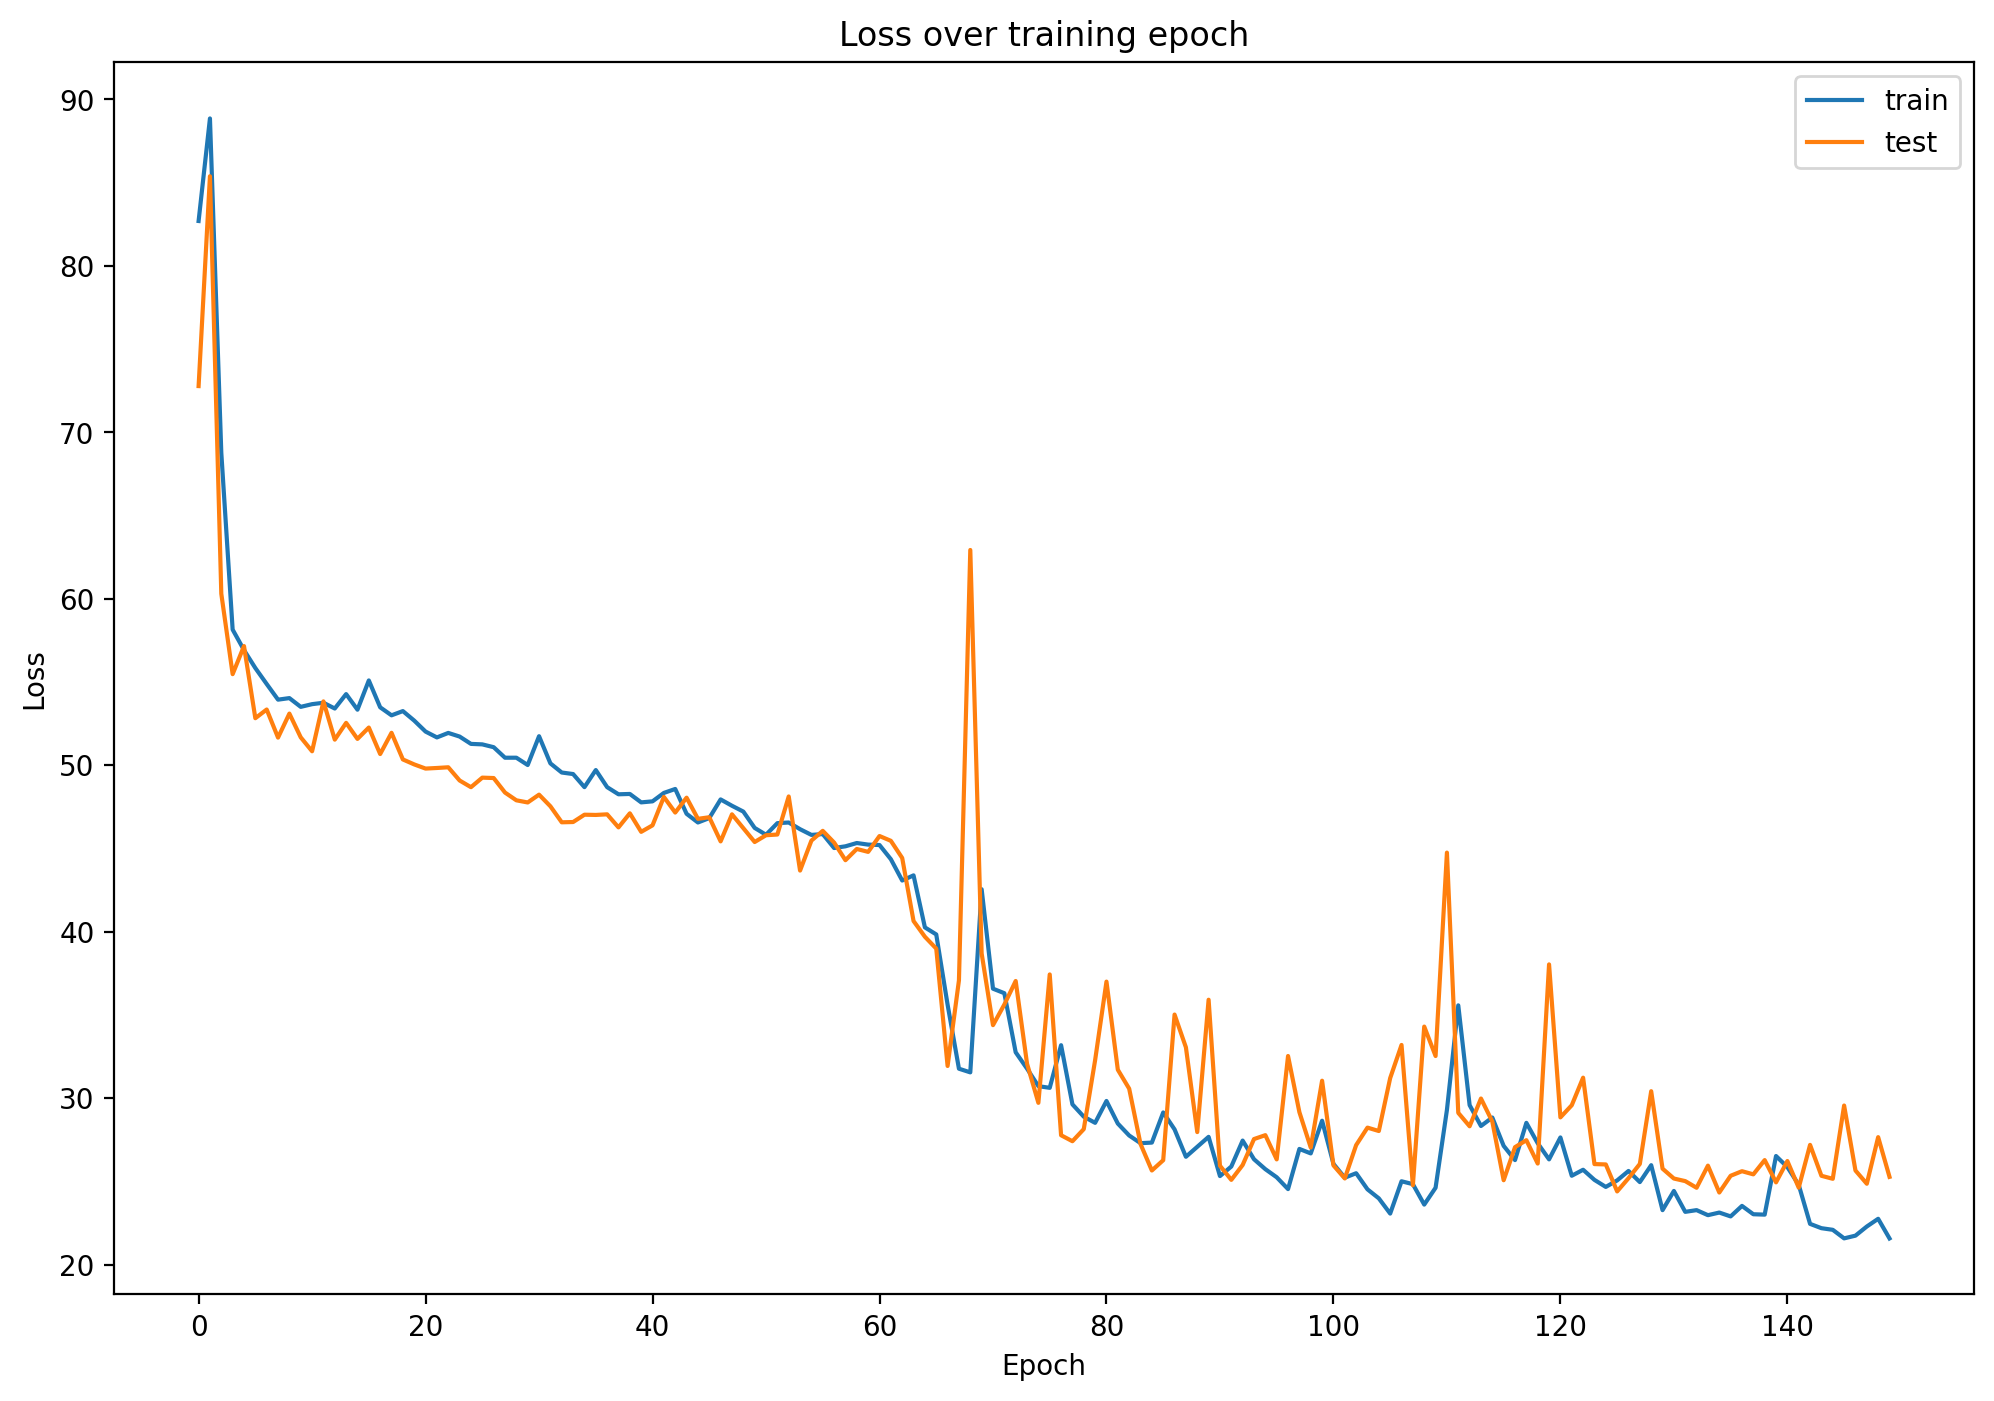

In [62]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epoch')
plt.show()

In [63]:
# Save the model
model_path = 'model.pth'
torch.save(model, model_path)

60


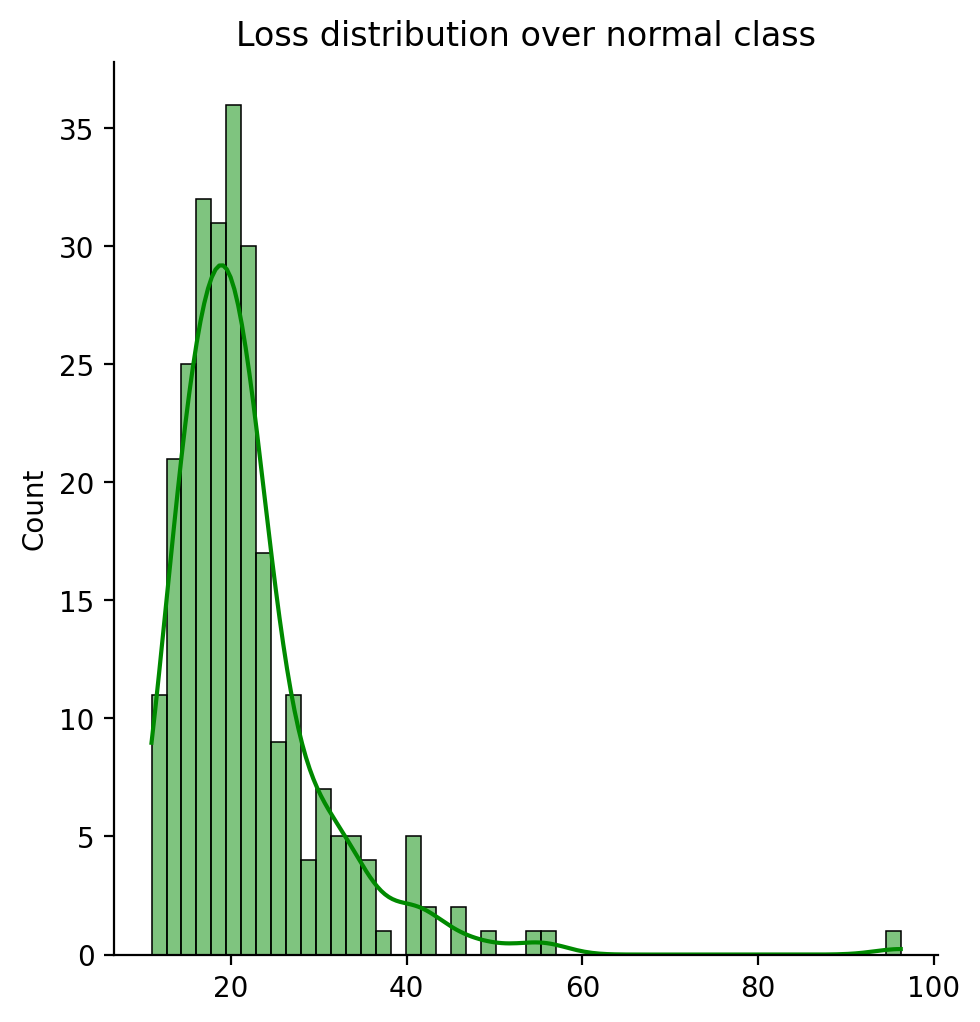

In [72]:
# Choose a threshold
def predict(model, dataset):
    predictions, losses = [], []
    criterion = nn.L1Loss(reduction='sum').to(device)
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.to(device)
            seq_pred = model(seq_true)
            loss = criterion(seq_pred, seq_true)

            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
        
    return predictions, losses

# Records predictions and losses
_, losses = predict(model, train_dataset)
sns.displot(losses, bins=50, kde=True, color='#008A00')
plt.title('Loss distribution over normal class')
# Set threshold (reasoning?)
# threshold = np.mean(losses) + 1.5 * np.std(losses)
threshold = 60
print(threshold)

In [ ]:
# Check model performance on anomalies
# Retrieve a subset of the same size as the normal dataset

test_normal_df = test_df[test_df['target'] == class_normal]
test_anomaly_df = test_df[test_df['target'] != class_normal]
print(test_normal_df.shape, test_anomaly_df.shape)

60
Correct normal predictions: 2553/2627 - percentage 97.18


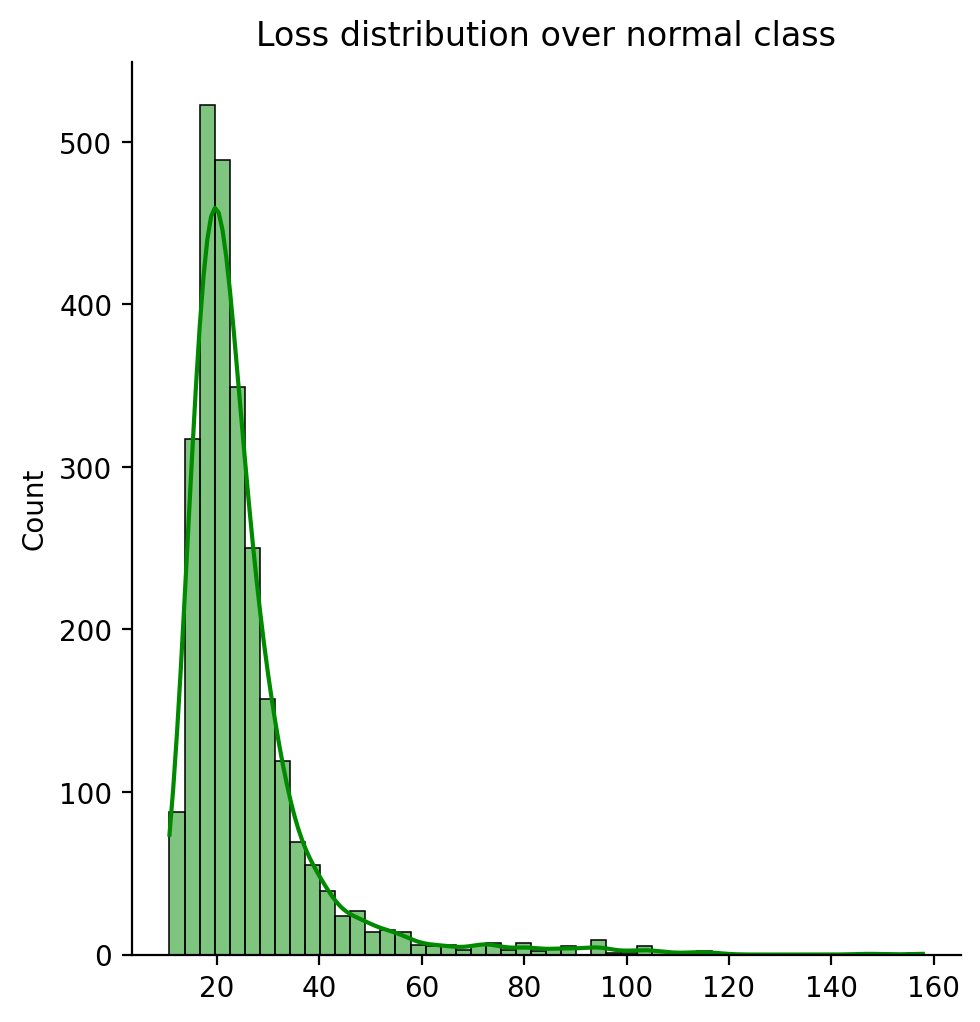

In [78]:

test_normal_dataset, _, _ = create_dataset(test_normal_df)
test_anomaly_dataset, _, _ = create_dataset(test_anomaly_df)

# Normal dataset is larger, retrieve subset of same length as anomaly dataset
# test_normal_dataset = test_normal_dataset[:len(test_anomaly_dataset)]
# test_anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

normal_predictions, normal_losses = predict(model, test_normal_dataset)
sns.displot(normal_losses, bins=50, kde=True, color='#008A00')
plt.title('Loss distribution over normal class')
# Set threshold (reasoning?)
# threshold = np.mean(losses) + 1.5 * np.std(losses)
threshold = 60
print(threshold)
plt.title('Loss distribution over normal class')
correct_normal = sum(l <= threshold for l in normal_losses)
print('Correct normal predictions: {}/{} - percentage {}'.format(correct_normal, len(test_normal_dataset), np.round(correct_normal / len(test_normal_dataset)* 100, 2)))

Correct anomaly predictions: 1831/1873 - percentage 97.76


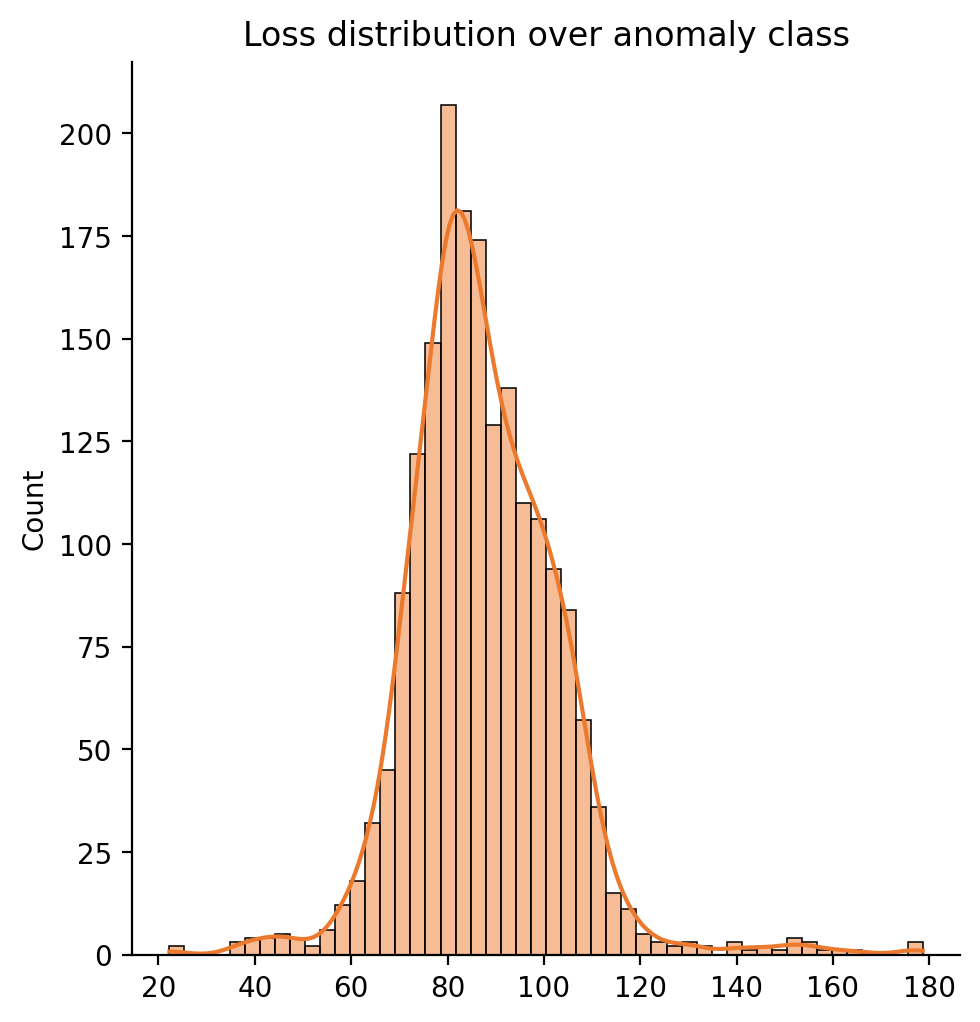

In [79]:
anomaly_predictions, anomaly_losses = predict(model, test_anomaly_dataset)
sns.displot(anomaly_losses, bins=50, kde=True, color='#EC7A2E')
plt.title('Loss distribution over anomaly class')
correct_anomaly = sum(l > threshold for l in anomaly_losses)
print('Correct anomaly predictions: {}/{} - percentage {}'.format(correct_anomaly, len(test_anomaly_dataset), np.round(correct_anomaly / len(test_anomaly_dataset)* 100, 2)))

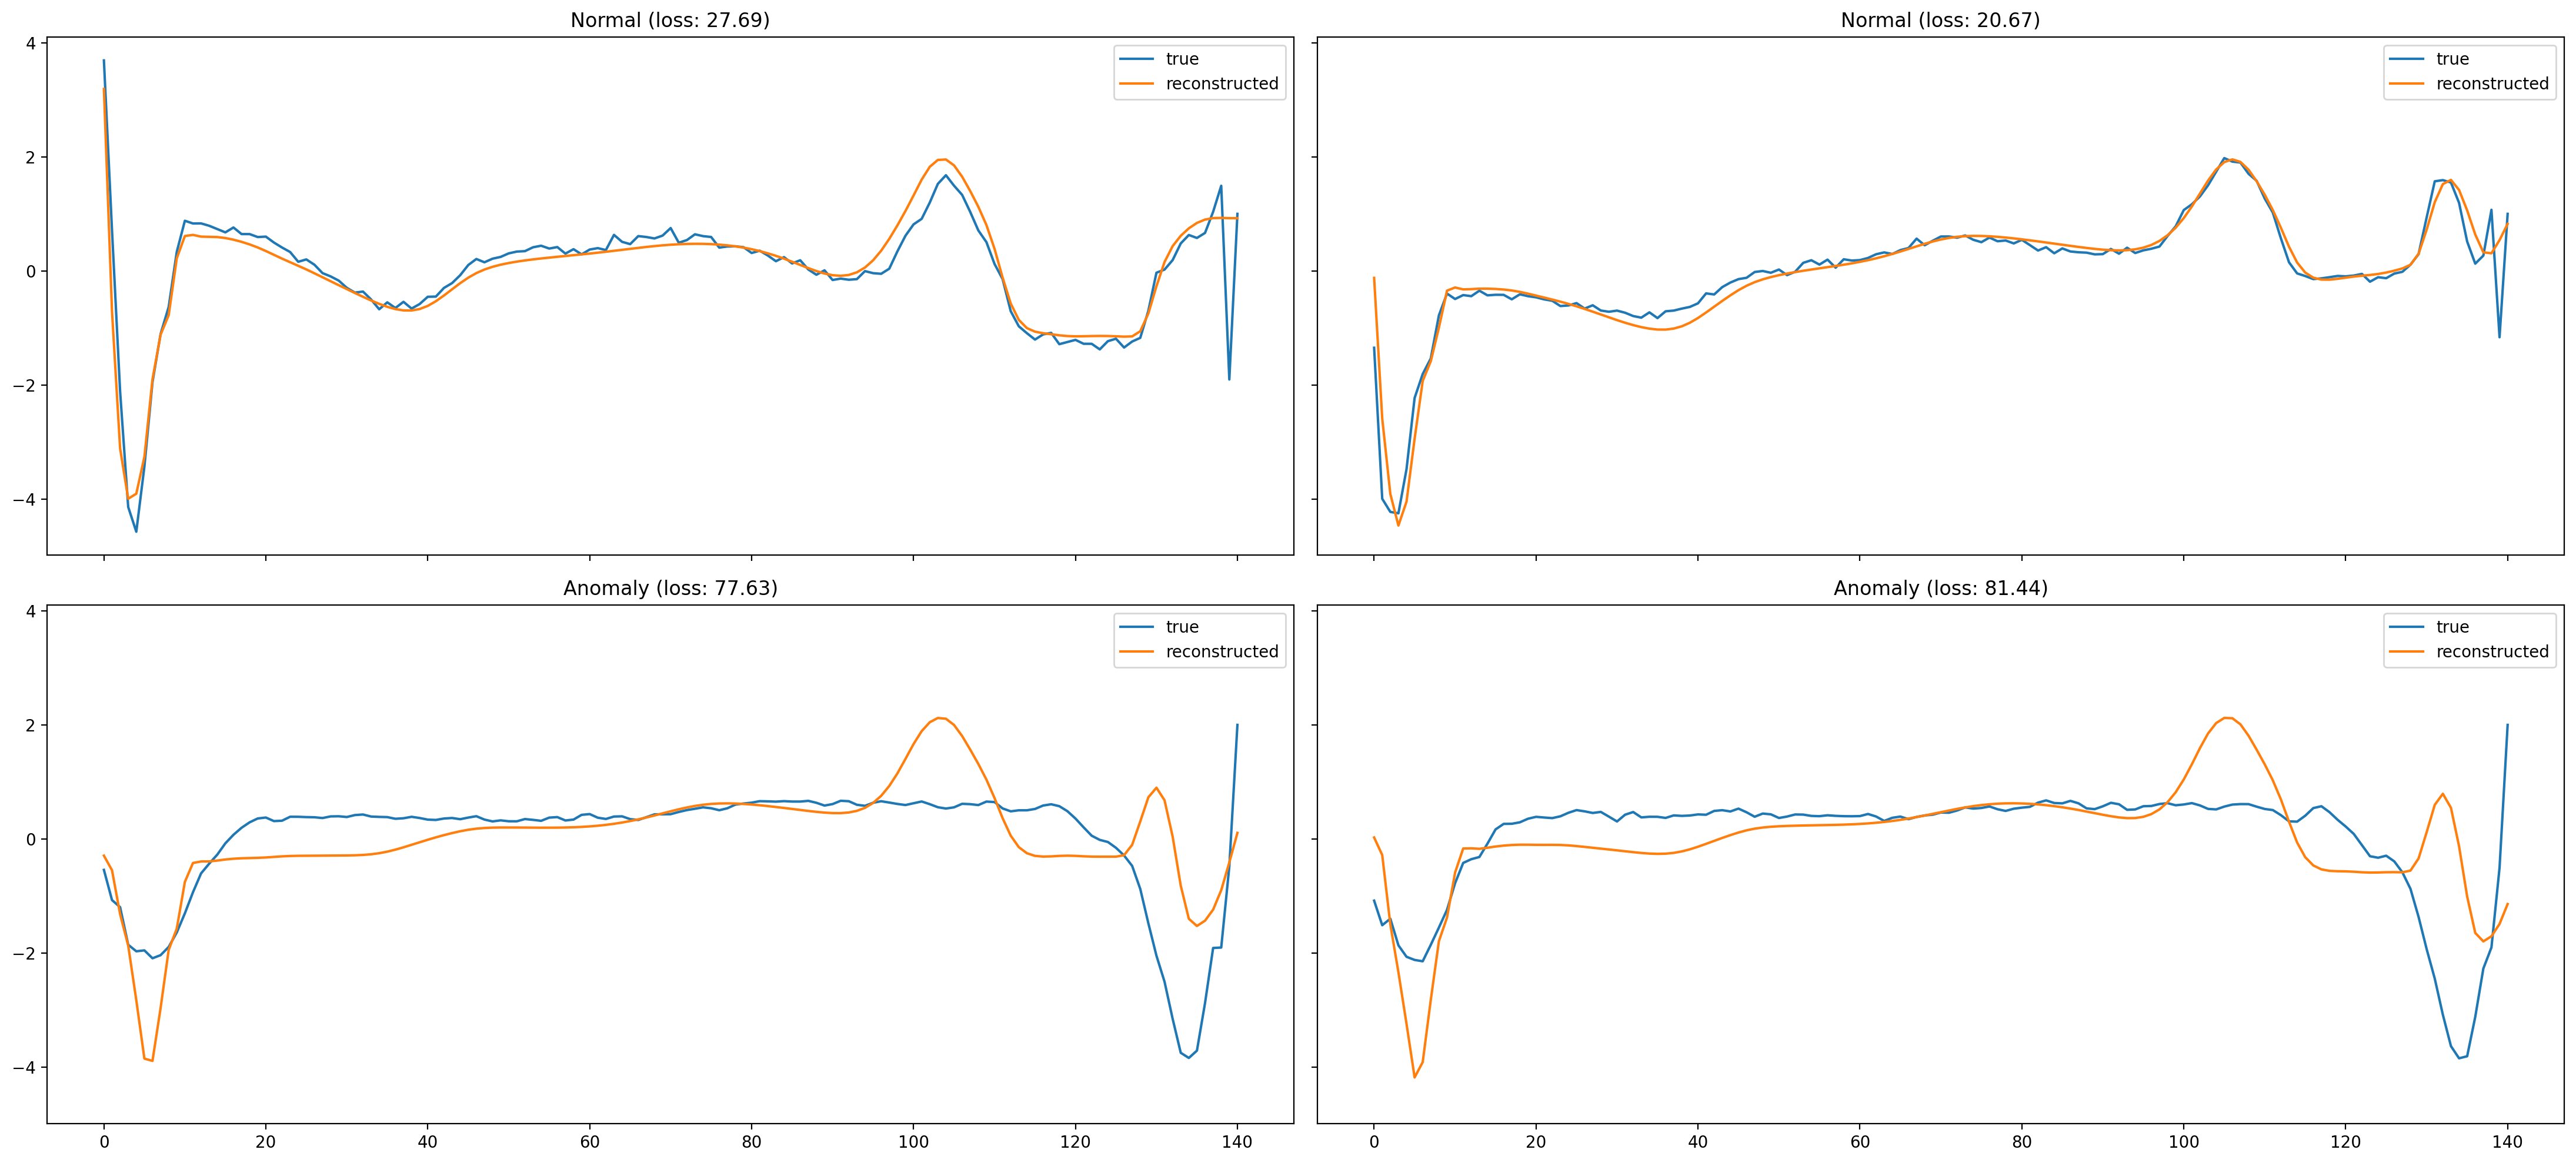

In [80]:
# Overlay real and constructed time series data for comparison

def plot_predictions(data, model, title, ax):
    predictions, losses = predict(model, [data])

    ax.plot(data, label='true')
    ax.plot(predictions[0], label='reconstructed')
    ax.set_title('{} (loss: {})'.format(title, np.around(losses[0], 2)))
    ax.legend()
n = 2
fig, axs = plt.subplots(2, n, sharey=True, sharex=True, figsize=(22,10))

for i, data in enumerate(test_normal_dataset[:n]):
    plot_predictions(data, model, title='Normal', ax=axs[0,i])
for j, data in enumerate(test_anomaly_dataset[:n]):
    plot_predictions(data, model, title='Anomaly', ax=axs[1,j])
fig.tight_layout()

In [69]:
x = torch.randn(1, 141).to(device)
torch.onnx.export(model, x, 'model.onnx', input_names=['input'], output_names=['output'])

c:\Users\ersav\Python Code\AteaFocusDemo\.venv\lib\site-packages\torch\onnx\symbolic_opset9.py:4545: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
